In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [2]:
input_array = np.expand_dims(np.arange(-1.5, 1.5, 0.01), axis=1)
output_array = np.sinc(5 * input_array)

In [3]:
print(input_array.shape)
print(output_array.shape)

(300, 1)
(300, 1)


In [4]:
x = torch.tensor(input_array, dtype=torch.float32)
y = torch.tensor(output_array, dtype=torch.float32)

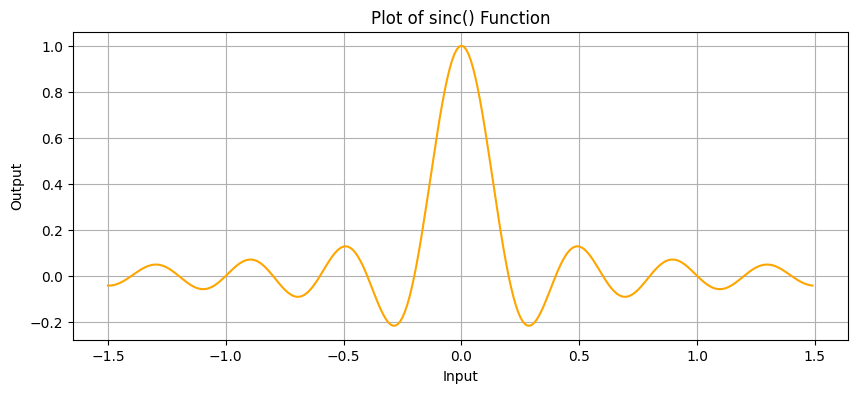

In [5]:
plt.figure(figsize=(10,4))
plt.plot(input_array, output_array, color="orange")
plt.title('Plot of sinc() Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)  # Add grid
plt.show()

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 12)
        self.linear_4 = nn.Linear(12, 10)
        self.linear_5 = nn.Linear(10, 10)
        self.linear_6 = nn.Linear(10, 10)
        self.linear_7 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)

    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear_1(x))
        x = nn.functional.leaky_relu(self.linear_2(x))
        x = nn.functional.leaky_relu(self.linear_3(x))
        x = nn.functional.leaky_relu(self.linear_4(x))
        x = nn.functional.leaky_relu(self.linear_5(x))
        x = nn.functional.leaky_relu(self.linear_6(x))
        x = nn.functional.leaky_relu(self.linear_7(x))

        x = self.predict(x)
        return x

In [7]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total params - ', total_params)

Total params -  572


In [8]:
def train_model(model, x, y):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0
    loss_val = 0
    minimal_ratio = 0
    print('Beginning training')

    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(x)
        loss_val = 0.001
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        # Calculate the gradient norm
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)

        total_params = sum(p.numel() for p in model.parameters())
        if grad_norm < 0.001 or epoch == epoch_size:
            print('Gradient norm reached minimum value')
            predicted_y = model(x)
            lossm = loss_func(predicted_y, y)
            H = torch.zeros((total_params, total_params))

            with torch.autograd.set_detect_anomaly(True):
                Jacob = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
                Jacob = torch.cat([e.flatten() for e in Jacob])  # flatten
                for i in range(total_params):
                    result = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
                    H[i] = torch.cat([r.flatten() for r in result])  # flatten
            H_eig = torch.linalg.eigvalsh(H, UPLO='U')
            positive_count = (H_eig > 0).sum().item()
            minimal_ratio = positive_count / H.shape[0]
            print('Minimal Ratio - ', minimal_ratio, ', Loss - ', lossm.data.detach().numpy(), ', Epoch - ', epoch)
            loss_val = lossm.data.detach().numpy()
            break

    print('Training Completed')
    return loss_val, minimal_ratio


In [9]:
loss_arr = []
min_ratio_arr = []

for index in range(100):
    print("Training model", index)
    model = Model()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    loss_value, min_ratio = train_model(model, x, y)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)


Training model 0
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5297202797202797 , Loss -  0.003581281 , Epoch -  477
Training Completed
Training model 1
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5559440559440559 , Loss -  0.0010787689 , Epoch -  1261
Training Completed
Training model 2
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5034965034965035 , Loss -  0.06135804 , Epoch -  656
Training Completed
Training model 3
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5332167832167832 , Loss -  0.002415212 , Epoch -  749
Training Completed
Training model 4
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5384615384615384 , Loss -  0.001475268 , Epoch -  1041
Training Completed
Training model 5
Beginning training
Gradient norm reached minimum value
Minimal Ratio -  0.5017482517482518 , Loss -  0.061310176 , Epoch -  180
Training Completed
Training model

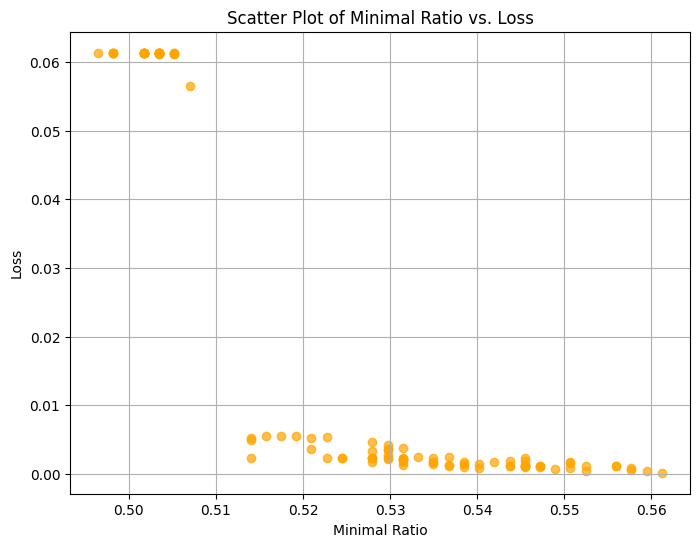

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(min_ratio_arr, loss_arr, color="orange", alpha=0.7)
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.title("Scatter Plot of Minimal Ratio vs. Loss")
plt.grid(True)
plt.show()